In [1]:
import sys
!{sys.executable} -m pip install autograd 

In [2]:
!pip install tensorflow-macos tensorflow-metal

In [3]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())

TensorFlow version: 2.16.2
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
!pip install scikit-learn
!pip install matplotlib
!pip install pandas

In [5]:
import autograd.numpy as np
import numpy as numpy
from autograd import grad, elementwise_grad
from sklearn.linear_model import LinearRegression, Lasso
import matplotlib.pylab as plt
import pandas as pd

In [6]:
###Utility Functions###
def generate_perturbed_X(X, delta, sampling, S, seed=0):
    np.random.seed(seed=seed)
    N = X.shape[0]
    D = X.shape[1]

    X_expanded = X[np.newaxis, :, :]
    if sampling == 'normal':
         epsilon_s = np.random.normal(0 , delta, size=(S, N, D))
         X_perturbed =  X_expanded + epsilon_s
    elif sampling == 'logitnormal':

        epsilon = 1e-6
        X_clipped = np.clip(X_expanded, epsilon, 1 - epsilon)
        # Apply the logit function to get log-odds
        X_logit = logit(X_clipped)

        # Correct noise shape here, broadcast compatible with `X_logit`
        noise_shape = (S, N, D)
        noise = np.random.normal(0, delta, size=noise_shape)

        # Add Gaussian noise to the log-odds
        noisy_X_logit = X_logit + noise

        # Convert back to probabilities and round the result if needed
        X_perturbed = expit(noisy_X_logit)
    else:
        raise  Exception('Sampling {} not defined,'.format('sampling'))

    return X_perturbed

In [7]:
def similarity(X_perturbed, X_original, sigma=2):
    '''
    kernel_fn: computes the similarity between perturbed inputs and the original input
    input:
        X_perturbed(S, D): S perturbed versions of the input, each with D features
        X_original(D): the original input
        sigma: bandwidth for the Gaussian kernel
    output:
        pi_x(S): array of similarity scores for each perturbed sample
    '''
    distance = np.linalg.norm(X_perturbed - X_original, axis=1)
    pi_x = np.exp(-distance ** 2 / (sigma ** 2))

    return pi_x

In [8]:
def compute_LIME_explanations(X, X_perturbed, fn, y_sample):
    """
    Compute a matrix of explanations for each sample.
    Parameters:
        X (np.array): Original dataset of shape (N, D).
        X_perturbed (np.array): Perturbed inputs of shape (S, N, D).
        fn (function): Model to explain.
        y_sample (np.array): Target classes for each sample in X.
    Returns:
        np.array: Explanations matrix of shape (N, D).
    """
    S, N, D = X_perturbed.shape
    Explanations = np.zeros((N, D))
    linear_model = LinearRegression()  # Instantiate the regression model once
    # lasso_model = Lasso(alpha=0.001, max_iter=1000)

    for i in range(N):
        print(i)
        perturbed_sample_i = X_perturbed[:, i, :]
        target = fn(perturbed_sample_i)
        # Extract the revelant score for the corresponding class
        target_class = target[:, y_sample[i]]

        # Compute coefficients for the current sample
        pi_x = similarity(perturbed_sample_i, X[i])
        print(f"pi_x min: {pi_x.min()}, max: {pi_x.max()}, sum: {pi_x.sum()}")
        linear_model.fit(perturbed_sample_i, target_class, sample_weight=pi_x)

        # lasso_model.fit(perturbed_sample_i, target_class, sample_weight=pi_x) 
        # coef = lasso_model.coef_
        
        coef = linear_model.coef_
        Explanations[i, :] = np.abs(coef)  # Store absolute values of coefficients

    return Explanations


In [9]:
def generate_perturbed_conv_outputs(conv_outputs, delta, sampling, S, seed=0):
    """
    Generate perturbed convolutional outputs.

    Parameters:
        conv_outputs (np.array): Original convolutional outputs of shape (N, H, W, C).
        delta (float): Perturbation scale.
        sampling (str): Type of perturbation ('normal').
        S (int): Number of perturbed samples.
        seed (int): Random seed for reproducibility.

    Returns:
        np.array: Perturbed convolutional outputs of shape (S, N, H, W, C).
    """
    np.random.seed(seed)
    N, H, W, C = conv_outputs.shape

    if sampling == 'normal':
        epsilon_s = np.random.normal(0, delta, size=(S, N, H, W, C))
        conv_outputs_perturbed = conv_outputs[np.newaxis, ...] + epsilon_s
    else:
        raise NotImplementedError(f"Sampling '{sampling}' is not implemented.")

    return conv_outputs_perturbed


In [40]:
def compute_conv_LIME_explanations(conv_outputs, conv_outputs_perturbed, fn, y_sample):
    """
    Compute explanations for convolutional feature maps.

    Parameters:
        conv_outputs (np.array): Original convolutional outputs of shape (N, H, W, C).
        conv_outputs_perturbed (np.array): Perturbed convolutional outputs of shape (S, N, H, W, C).
        fn (function): Sub-model function to compute predictions.
        y_sample (np.array): Target classes for each sample.

    Returns:
        np.array: Explanations matrix of shape (N, C).
    """
    S, N, H, W, C = conv_outputs_perturbed.shape
    explanations = np.zeros((N, C))  # Store explanations for each feature map
    linear_model = LinearRegression()  # Instantiate the regression model once

    for i in range(N):
        print(i)
        perturbed_sample_i = conv_outputs_perturbed[:, i, :, :, :]  # Shape: (S, H, W, C)
        perturbed_sample_i_flat = perturbed_sample_i.reshape(S, -1)  # Shape: (S, H * W * C)
        original_sample_flat = conv_outputs[i].reshape(-1)  # Shape: (H * W * C)

        # Predict target outputs for perturbed samples
        target = fn(perturbed_sample_i)  # Shape: (S, num_classes)
        target_class = target[:, y_sample[i]]  # Relevant scores for the class of interest

        # Compute similarity weights
        pi_x = similarity(perturbed_sample_i_flat, original_sample_flat, 500)
        pi_x = pi_x / np.max(pi_x)  # Normalize to [0, 1]
        print(f"pi_x min: {pi_x.min()}, max: {pi_x.max()}, sum: {pi_x.sum()}")

        # Fit the linear model to compute explanations
        target_class += 1e-6  # Add a small constant to stabilize regression
        linear_model.fit(perturbed_sample_i_flat, target_class, sample_weight=pi_x)

        # Store absolute coefficients as feature importance
        coef = linear_model.coef_.reshape(H, W, C)  # Reshape to match spatial dimensions
        explanations[i, :] = np.abs(coef.mean(axis=(0, 1)))  # Aggregate over spatial dimensions

    return explanations


In [11]:
def LIME_global_mean(explanations, y_sample=None, class_of_interest=None):
    """
    Compute the mean explanation for all samples, or filter by class if specified.
    Parameters:
        explanations (np.array): Explanation matrix of shape (N, D).
        y_sample (np.array, optional): Array of true class labels of shape (N,). Required if filtering by class.
        class_of_interest (int, optional): The class for which to filter explanations.
    Returns:
        np.array: Mean explanation vector of shape (D,).
    """
    if class_of_interest is not None:
        if y_sample is None:
            raise ValueError("y_sample must be provided if class_of_interest is specified.")
        
        # Filter explanations for the class of interest
        target_indices = y_sample == class_of_interest
        filtered_explanations = explanations[target_indices, :]
        # Compute the mean explanation for the filtered data
        mean_explanation = np.mean(filtered_explanations, axis=0)
    else:
        # Compute the mean explanation for all samples
        mean_explanation = np.mean(exp, axis=0)
    
    return mean_explanation


In [12]:
def LIME_global_paper(explanations, y_sample=None, class_of_interest=None):
    """
    Aggregate the explanations matrix using the formula sqrt(sum(|W_ij|)) for each feature.
    If class_of_interest is specified, filters the explanations first.
    Parameters:
        explanations (np.array): Explanation matrix of shape (N, D).
        y_sample (np.array, optional): Array of true class labels of shape (N,).
        class_of_interest (int, optional): The class for which to filter explanations.
    Returns:
        np.array: Aggregated explanations of shape (D,).
    """
    if class_of_interest is not None:
        if y_sample is None:
            raise ValueError("y_sample must be provided if class_of_interest is specified.")
        # Filter explanations for the class of interest
        target_indices = y_sample == class_of_interest
        explanations = explanations[target_indices, :]
    
    # Compute the aggregation for each feature
    return np.sqrt(np.sum(np.abs(explanations), axis=0))


In [13]:
def LIME_global_normalization(explanations, y_sample=None, class_of_interest=None):
    """
    Compute global LIME explanations by aggregating over all samples with normalization.
    If class_of_interest is specified, filters the explanations first.
    Parameters:
        explanations (np.array): Explanation matrix of shape (N, D).
        y_sample (np.array, optional): Array of true class labels of shape (N,).
        class_of_interest (int, optional): The class for which to filter explanations.
    Returns:
        np.array: Normalized global explanations of shape (D,).
    """
    if class_of_interest is not None:
        if y_sample is None:
            raise ValueError("y_sample must be provided if class_of_interest is specified.")
        # Filter explanations for the class of interest
        target_indices = y_sample == class_of_interest
        explanations = explanations[target_indices, :]

    # Compute normalized global explanations
    non_zero = np.sum(explanations > 0, axis=0)
    non_zero_sum = np.sum(explanations, axis=0)
    Global = non_zero_sum / non_zero
    Global[np.isnan(Global)] = 0  # Handle division by zero

    return Global

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np
from scipy.special import expit, logit
import matplotlib.pyplot as plt

In [15]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape data to add channel dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

x_train shape: (60000, 28, 28, 1), x_test shape: (10000, 28, 28, 1)


In [16]:
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    # Block 1: Convolution + MaxPooling
    layers.Input(shape=(28, 28, 1)),  # Explicit Input layer
    layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_1'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2: Convolution + MaxPooling
    layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_2'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # Output layer for classification
])

# Print the model summary
model.summary()


2024-12-08 04:32:10.556807: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-08 04:32:10.556857: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-08 04:32:10.556870: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-08 04:32:10.556910: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-08 04:32:10.556939: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
model.fit(x_train, y_train, epochs=10, validation_split=0.1)

Epoch 1/10


2024-12-08 04:32:13.493552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.6373 - loss: 1.6646 - val_accuracy: 0.9673 - val_loss: 0.2959
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.8762 - loss: 1.9535 - val_accuracy: 0.9632 - val_loss: 1.6974
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.8958 - loss: 7.9237 - val_accuracy: 0.9755 - val_loss: 3.7287
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.9109 - loss: 16.6017 - val_accuracy: 0.9762 - val_loss: 6.7268
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.9215 - loss: 28.0847 - val_accuracy: 0.9793 - val_loss: 11.5211
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9262 - loss: 47.9240 - val_accuracy: 0.9727 - val_loss: 25.0617
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9339 - loss: 69.8201 - val_accuracy: 0.9827 - val_loss: 27.0211
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.9313 - los

In [20]:
model.save('trained_model.h5')

In [19]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9758 - loss: 73.0451
Test accuracy: 0.9805999994277954


In [21]:
sampling = "normal"
S = 1000
delta = 0.25
num_points = 500

# Take a subset of test data to explain
indices = np.random.choice(x_test.shape[0], num_points, replace=False)
x_sample = x_test[indices]
y_sample = y_test[indices]

N = x_sample.shape[0]
X = x_sample.reshape(x_sample.shape[0], -1)
D = X.shape[1]
X_perturbed = generate_perturbed_X(X, delta, sampling, S)

print("Perturbed Outputs Range:", X_perturbed.min(), X_perturbed.max())

fn = lambda x: model.predict(x.reshape(x.shape[0], 28, 28, 1))

Perturbed Outputs Range: -1.502436654926034 2.353514531471994


In [25]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, Model

# Step 1: Load the trained Sequential model
trained_model = load_model('trained_model.h5')

# Step 2: Define a new Functional API model with the same architecture
inputs = layers.Input(shape=(28, 28, 1), name='input_layer')
x = layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_1')(inputs)
x = layers.MaxPooling2D((2, 2), name='maxpool_1')(x)
x = layers.Dropout(0.25, name='dropout_1')(x)

x = layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_2')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_2')(x)
x = layers.Dropout(0.25, name='dropout_2')(x)

x = layers.Flatten(name='flatten')(x)
x = layers.Dense(128, activation='relu', name='dense_1')(x)
x = layers.Dropout(0.5, name='dropout_3')(x)
x = layers.Dense(128, activation='relu', name='dense_2')(x)
x = layers.Dropout(0.5, name='dropout_4')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

functional_model = Model(inputs=inputs, outputs=outputs, name='functional_model')

# Step 3: Transfer weights from the trained Sequential model
functional_model.set_weights(trained_model.get_weights())

# Verify that weights are transferred
for layer in functional_model.layers:
    print(f"Layer {layer.name}: Weights Transferred")
    
# Step 4: Extract intermediate outputs for `conv2d_2`
conv_layer_name = 'conv2d_2'
conv_model = Model(inputs=functional_model.input, outputs=functional_model.get_layer(conv_layer_name).output)

# Remaining model for predictions after `conv2d_2`
remaining_model = Model(
    inputs=conv_model.output,
    outputs=functional_model.output
)

# Step 5: Test the combined accuracy
indices_conv = np.random.choice(x_test.shape[0], num_points, replace=False)
x_sample_conv = x_test[indices_conv]
y_sample_conv = y_test[indices_conv]

# Get outputs from the second convolutional layer
conv_outputs = conv_model.predict(x_sample_conv)
print("Shape of conv2d_2 outputs:", conv_outputs.shape)

# Use the remaining model for predictions
combined_predictions = remaining_model.predict(conv_outputs)
combined_accuracy = np.mean(np.argmax(combined_predictions, axis=1) == y_sample_conv)
print(f"Combined model accuracy: {combined_accuracy * 100:.2f}%")

# Sample data
indices_conv = np.random.choice(x_test.shape[0], num_points, replace=False)
x_sample_conv = x_test[indices_conv]
y_sample_conv = y_test[indices_conv]

# Get outputs from the second convolutional layer
conv_outputs = conv_model.predict(x_sample_conv)

# Generate perturbed convolutional layer outputs
S_conv = 200  # Number of perturbed samples
delta_conv = 25  # Perturbation scale
sampling = 'normal'  # Type of sampling
conv_outputs_perturbed = generate_perturbed_conv_outputs(conv_outputs, delta_conv, sampling, S_conv)

# Define fn_conv to use the remaining model for predictions
fn_conv = lambda x: remaining_model.predict(x)

Layer input_layer: Weights Transferred
Layer conv2d_1: Weights Transferred
Layer maxpool_1: Weights Transferred
Layer dropout_1: Weights Transferred
Layer conv2d_2: Weights Transferred
Layer maxpool_2: Weights Transferred
Layer dropout_2: Weights Transferred
Layer flatten: Weights Transferred
Layer dense_1: Weights Transferred
Layer dropout_3: Weights Transferred
Layer dense_2: Weights Transferred
Layer dropout_4: Weights Transferred
Layer output_layer: Weights Transferred
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Shape of conv2d_2 outputs: (500, 11, 11, 64)
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Combined model accuracy: 97.60%
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [97]:
def output_statistics(outputs, name="Outputs"):
    """
    Print statistics for a given set of outputs.
    
    Parameters:
        outputs (np.array): The array of outputs to analyze.
        name (str): Name to use in the printed statistics.
    """
    print(f"{name} Statistics:")
    print(f"  Min: {np.min(outputs)}")
    print(f"  Max: {np.max(outputs)}")
    print(f"  Mean: {np.mean(outputs)}")
    print(f"  Std Dev: {np.std(outputs)}")
    print(f"  Percentiles:")
    print(f"    1st: {np.percentile(outputs, 1)}")
    print(f"    25th: {np.percentile(outputs, 25)}")
    print(f"    Median (50th): {np.percentile(outputs, 50)}")
    print(f"    75th: {np.percentile(outputs, 75)}")
    print(f"    99th: {np.percentile(outputs, 99)}")

In [101]:
# Analyze the original outputs
output_statistics(X, name="Original Outputs")

# Analyze the perturbed outputs
output_statistics(X_perturbed, name="Perturbed Outputs")

Original Outputs Statistics:
  Min: 0.0
  Max: 1.0
  Mean: 0.13282497999199677
  Std Dev: 0.31096170958606933
  Percentiles:
    1st: 0.0
    25th: 0.0
    Median (50th): 0.0
    75th: 0.0
    99th: 0.996078431372549
Perturbed Outputs Statistics:
  Min: -1.502436654926034
  Max: 2.330065932775005
  Mean: 0.13284388252837617
  Std Dev: 0.39898302904584415
  Percentiles:
    1st: -0.5627742783757359
    25th: -0.13016388291731623
    Median (50th): 0.061582640232392245
    75th: 0.29515225001153744
    99th: 1.3018496963460595


In [103]:
# Analyze the original outputs
output_statistics(conv_outputs, name="Original Conv2D_2 Outputs")

# Analyze the perturbed outputs
output_statistics(conv_outputs_perturbed, name="Perturbed Conv2D_2 Outputs")

Original Conv2D_2 Outputs Statistics:
  Min: 0.0
  Max: 166.71734619140625
  Mean: 6.949787616729736
  Std Dev: 18.256357192993164
  Percentiles:
    1st: 0.0
    25th: 0.0
    Median (50th): 0.0
    75th: 0.49317416548728943
    99th: 89.03862564086901
Perturbed Conv2D_2 Outputs Statistics:
  Min: -90.14619929556204
  Max: 221.10628050059267
  Mean: 6.950323634393607
  Std Dev: 23.62791022484325
  Percentiles:
    1st: -33.62412350026714
    25th: -7.74854343354291
    Median (50th): 3.508254433532746
    75th: 16.279931657579475
    99th: 93.30420387466657


In [23]:
explanations = compute_LIME_explanations(X, X_perturbed, fn, y_sample)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
pi_x min: 4.969834246008974e-07, max: 3.0019902268618067e-05, sum: 0.005933396359821438
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pi_x min: 5.916150045962397e-07, max: 3.732833396547206e-05, sum: 0.005830836681330841
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
pi_x min: 3.1779058276517985e-07, max: 3.138652108976741e-05, sum: 0.0057707423891074005
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
pi_x min: 6.420071960045676e-07, max: 3.0162073768606675e-05, sum: 0.005585839283371974
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
pi_x min: 6.587528146216972e-07, max: 3.1649957406804845e-05, sum: 0.005621880008452105
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pi_x min: 8.026356863143715e-07, max: 3.79328622963001e-05, sum: 0.005834910334487612
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pi_x min: 7.941788404371513e-07, max: 2.707193611378112e-05, sum: 0.005699956121473821
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
pi_x min: 7.607299138038518e-07, max: 3.51799645062955

In [41]:
conv_explanations = compute_conv_LIME_explanations(conv_outputs, conv_outputs_perturbed, fn_conv, y_sample_conv)

0
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
pi_x min: 0.18857815095307723, max: 1.0, sum: 99.22020314984474
1
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
pi_x min: 0.25081286237991285, max: 1.0, sum: 105.36284436171141
2
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
pi_x min: 0.2298545767812578, max: 1.0, sum: 103.15094972935589
3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
pi_x min: 0.1884277121598673, max: 1.0, sum: 99.08250244895305
4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
pi_x min: 0.16233152897411818, max: 1.0, sum: 94.71820965423406
5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
pi_x min: 0.16583587838595248, max: 1.0, sum: 82.06018132834157
6
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
pi_x min: 0.16547091672383543, max: 1.0, sum: 97.12043621089794
7
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
pi_x min: 0.17043820793850778, max: 1.0, sum: 84.1739880915388
8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
pi_x min: 0.16659546355374774, max: 1.0, sum: 101.15442402473265
9
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
pi_x min: 0.1889813619476679, m

In [42]:
output_csv_path = 'conv_explanations.csv'
conv_explanations_df = pd.DataFrame(conv_explanations)
conv_explanations_df.to_csv(output_csv_path, index=False)

print(f"conv_explanations saved to {output_csv_path}")

conv_explanations saved to conv_explanations.csv


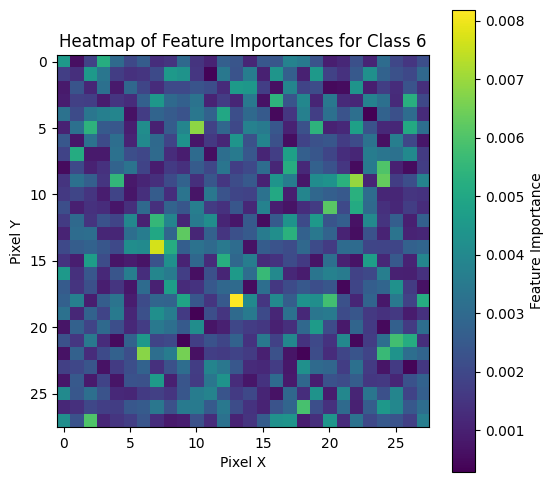

In [43]:
# Plot a simple average of all explanations for "class of interest" given that the actual digit is "class of interest"
class_of_interest = 6
mean_explanation = LIME_global_mean(explanations, y_sample = y_sample, class_of_interest = class_of_interest)

# Reshape to 28x28
heatmap_average = mean_explanation.reshape(28, 28)

# Plot the heatmap
plt.figure(figsize=(6, 6))
plt.imshow(heatmap_average, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Feature Importance')
plt.title(f'Heatmap of Feature Importances for Class {class_of_interest}')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

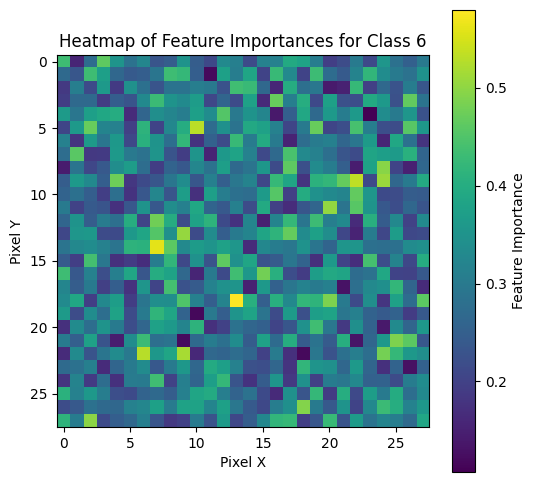

In [44]:
# Plot a simple sqrt sum of all explanations for "class of interest" given that the actual digit is "class of interest"
sum_explanation = LIME_global_paper(explanations, y_sample = y_sample, class_of_interest = 6)

# Reshape to 28x28
heatmap_paper = sum_explanation.reshape(28, 28)

# Plot the heatmap
plt.figure(figsize=(6, 6))
plt.imshow(heatmap_paper, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Feature Importance')
plt.title(f'Heatmap of Feature Importances for Class {class_of_interest}')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

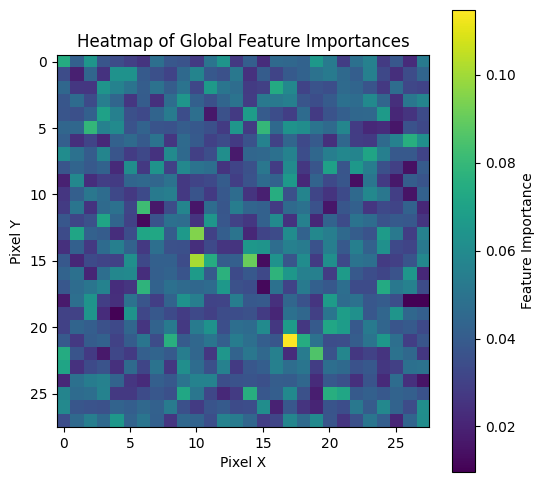

In [45]:
# Generate explanations
global_exp_norm = LIME_global_normalization(explanations, y_sample = y_sample, class_of_interest = 2)

# Reshape to 28x28
heatmap_norm = global_exp_norm.reshape(28, 28)

# Plot the heatmap
plt.figure(figsize=(6, 6))
plt.imshow(heatmap_norm, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Feature Importance')
plt.title('Heatmap of Global Feature Importances')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

In [46]:
def mask_top_pixels(data, top_n):
    """
    Mask all but the top_n most important pixels in the data.
    
    Parameters:
        data (np.array): 1D array of feature importances.
        top_n (int): Number of top pixels to retain.
        
    Returns:
        np.array: Masked 1D array with only the top_n pixels retained.
    """
    # Flatten the data to sort
    flat_data = data.flatten()
    # Find the threshold for the top_n largest values
    threshold = np.partition(flat_data, -top_n)[-top_n]
    # Create a mask for pixels above the threshold
    masked_data = np.where(flat_data >= threshold, flat_data, 0)
    return masked_data.reshape(data.shape)

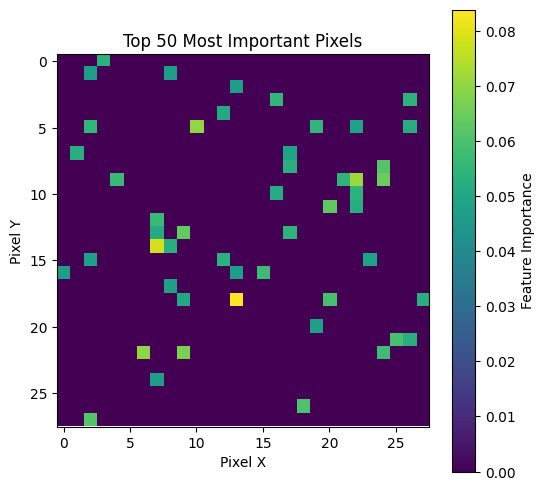

In [47]:
# Generate explanations
global_exp_norm = LIME_global_normalization(explanations, y_sample=y_sample, class_of_interest=6)

# Reshape to 28x28
heatmap_norm_masked = global_exp_norm.reshape(28, 28)

# Mask all but the top 50 most important pixels
heatmap_norm_masked = mask_top_pixels(heatmap_norm_masked, top_n=50)

# Plot the masked heatmap
plt.figure(figsize=(6, 6))
plt.imshow(heatmap_norm_masked, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Feature Importance')
plt.title('Top 50 Most Important Pixels')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

def save_and_plot_explanations(exp, y_sample, method='simple', data_type='original', output_prefix='explanations'):
    """
    Save explanations for each class using simple averaging or normalization
    and plot heatmaps for each explanation.
    
    Parameters:
        exp (np.array): Explanation matrix of shape (N, D) for original, or (N, C) for convolutional.
        y_sample (np.array): Array of true class labels of shape (N,).
        method (str): Aggregation method, either 'simple', 'paper', or 'normalization'.
        data_type (str): Type of data to process, either 'original' or 'convolutional'.
        output_prefix (str): Prefix for the output CSV and plot files.
    """
    for class_of_interest in range(10):  # Assuming 10 classes (0–9)
        # Select the aggregation method
        if method == 'simple':
            mean_explanation = LIME_global_mean(exp, y_sample=y_sample, class_of_interest=class_of_interest)
        elif method == 'paper':
            mean_explanation = LIME_global_paper(exp, y_sample=y_sample, class_of_interest=class_of_interest)
        elif method == 'normalization':
            mean_explanation = LIME_global_normalization(exp, y_sample=y_sample, class_of_interest=class_of_interest)
        else:
            raise ValueError("Invalid method. Use 'simple', 'paper', or 'normalization'.")
        
        # Reshape the explanation based on data_type
        if data_type == 'original':
            mean_explanation_reshaped = mean_explanation.reshape(28, 28)  # Assuming input images are 28x28
        elif data_type == 'convolutional':
            # Handle convolutional explanation (N, C)
            num_channels = mean_explanation.shape[-1]  # Number of feature maps (C)
            mean_explanation_reshaped = mean_explanation  # No further reshaping for feature maps
        else:
            raise ValueError("Invalid data_type. Use 'original' or 'convolutional'.")
        
        # Save to CSV
        if data_type == 'original':
            df = pd.DataFrame(mean_explanation_reshaped)
        elif data_type == 'convolutional':
            df = pd.DataFrame(mean_explanation_reshaped)  # Save directly for (C,) explanations

        df.to_csv(f'{output_prefix}_class_{class_of_interest}_{data_type}.csv', index=False, header=True)
        
        # Plot the heatmap or bar chart
        plt.figure(figsize=(6, 6))
        if data_type == 'original':
            plt.imshow(mean_explanation_reshaped, cmap='viridis', interpolation='nearest')
            plt.colorbar(label='Feature Importance')
            plt.title(f'{method.capitalize()} Explanation ({data_type.capitalize()}) for Class {class_of_interest}')
            plt.xlabel('Pixel X')
            plt.ylabel('Pixel Y')
        elif data_type == 'convolutional':
            plt.bar(range(mean_explanation_reshaped.shape[0]), mean_explanation_reshaped)
            plt.title(f'{method.capitalize()} Explanation ({data_type.capitalize()}) for Class {class_of_interest}')
            plt.xlabel('Feature Map Index')
            plt.ylabel('Feature Importance')
        
        # Save the plot
        plt.savefig(f'{output_prefix}_class_{class_of_interest}_{data_type}.png')
        plt.close()  # Close the plot to free memory


In [49]:
# Generate explanations with pixels
save_and_plot_explanations(explanations, y_sample, method='simple', data_type='original', output_prefix='simple_avg')
save_and_plot_explanations(explanations, y_sample, method='paper', data_type='original', output_prefix='paper')
save_and_plot_explanations(explanations, y_sample, method='normalization', data_type='original', output_prefix='normalized')

# Generate explanations with convolutional feature
save_and_plot_explanations(conv_explanations, y_sample_conv, method='simple', data_type='convolutional', output_prefix='simple_avg')
save_and_plot_explanations(conv_explanations, y_sample_conv, method='paper', data_type='convolutional', output_prefix='paper')
save_and_plot_explanations(conv_explanations, y_sample_conv, method='normalization', data_type='convolutional', output_prefix='normalized')

In [62]:
from datetime import datetime

def run_one_class(x_train, y_train, x_test, y_test, class_of_interest, n_runs):
    """
    Run pruning for a single class multiple times and save results.

    Parameters:
        x_train (np.array): Training data of shape (N, H, W, C).
        y_train (np.array): Training labels.
        x_test (np.array): Test data of shape (M, H, W, C).
        y_test (np.array): Test labels.
        class_of_interest (int): Class index to run pruning for.
        n_runs (int): Number of runs to perform.
    """
    methods = ['simple_avg', 'paper', 'normalized']
    pruning_ratios = np.linspace(0.1, 0.9, 9)  # Prune 10% to 90%
    all_accuracies = {method: [] for method in methods}  # Store accuracies for all runs

    for i in range(n_runs):
        for method in methods:
            # Load the explanation CSV for this class and method
            csv_path = f'{method}_class_{class_of_interest}_original.csv'
            importances = pd.read_csv(csv_path).to_numpy()
            
            # Flatten importances to match feature space
            importances_flat = importances.flatten()
            
            # Sort indices in ascending order of importance
            sorted_indices = np.argsort(importances_flat)
            
            accuracies = []
            X_copy = np.copy(x_train)
            
            # Perform pruning for each ratio
            for p in pruning_ratios:
                # Prune the least important features
                threshold_index = int(p * len(sorted_indices))
                prune_indices = sorted_indices[:threshold_index]
                mask = np.ones_like(importances_flat, dtype=bool)
                mask[prune_indices] = False
                mask = mask.reshape(28, 28)
                replicated_mask = np.tile(mask[:, :, np.newaxis], (x_train.shape[0], 1, 1, 1))
                X_copy = X_copy * replicated_mask

                print(f"class {class_of_interest}{i}th run {method}{p}% ratio")
                # Build and train the model
                model = models.Sequential([
                    # Block 1: Convolution + MaxPooling
                    layers.Input(shape=(28, 28, 1)),  # Explicit Input layer
                    layers.Conv2D(32, (3, 3), activation='relu'),
                    layers.MaxPooling2D((2, 2)),
                    layers.Dropout(0.25),
                
                    # Block 2: Convolution + MaxPooling
                    layers.Conv2D(64, (3, 3), activation='relu'),
                    layers.MaxPooling2D((2, 2)),
                    layers.Dropout(0.25),
                
                    # Fully Connected Layers
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dropout(0.5),
                    layers.Dense(128, activation='relu'),
                    layers.Dropout(0.5),
                    layers.Dense(10, activation='softmax')  # Output layer for classification
                ])
                
                model.compile(optimizer='adam',
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])
                
                model.fit(X_copy, y_train, epochs=5, validation_split=0.1, verbose=0)
                _, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
                accuracies.append(test_accuracy)
                del model
            
            # Append results for this method
            all_accuracies[method].append(accuracies)

    # Average accuracies across all runs for each method
    avg_accuracies = {method: np.mean(all_accuracies[method], axis=0) for method in methods}

    # Save results to a timestamped CSV file
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    accuracy_save_path = f'pruning_accuracy_class_{class_of_interest}_{timestamp}.csv'
    df = pd.DataFrame({'Pruning Ratio (%)': pruning_ratios * 100})
    for method, avg_acc in avg_accuracies.items():
        df[method.replace('_', ' ').capitalize()] = avg_acc
    df.to_csv(accuracy_save_path, index=False)

    # Plot the average accuracies and save the graph
    plt.figure(figsize=(8, 6))
    for method, avg_acc in avg_accuracies.items():
        plt.plot(pruning_ratios * 100, avg_acc, label=method.replace('_', ' ').capitalize())
    plt.title(f'Average Pruning Accuracy for Class {class_of_interest}')
    plt.xlabel('Pruned Features (%)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    graph_save_path = f'pruning_accuracy_class_{class_of_interest}_{timestamp}.png'
    plt.savefig(graph_save_path)
    plt.close()

In [63]:
def run_all_classes(x_train, y_train, x_test, y_test, n_runs):
    """
    Run pruning for all classes using run_one_class.

    Parameters:
        x_train (np.array): Training data of shape (N, H, W, C).
        y_train (np.array): Training labels.
        x_test (np.array): Test data of shape (M, H, W, C).
        y_test (np.array): Test labels.
        n_runs (int): Number of runs to perform for each class.
    """
    for class_of_interest in range(10):
        run_one_class(x_train, y_train, x_test, y_test, class_of_interest, n_runs)

In [ ]:
run_one_class(x_train, y_train, x_test, y_test, class_of_interest = 1, n_runs = 5)

In [ ]:
run_all_classes(x_train, y_train, x_test, y_test, n_runs = 5)

class 00th run simple_avg0.1% ratio
class 00th run simple_avg0.2% ratio
class 00th run simple_avg0.30000000000000004% ratio


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def run_one_class_convolutional(conv_model, remaining_model, conv_outputs, y_sample_conv, class_of_interest, n_runs):
    """
    Run pruning for a single class using convolutional feature maps, retraining the fully connected layers for each step.

    Parameters:
        conv_model: Model for extracting convolutional outputs.
        remaining_model: Remaining model for predictions (not used here; redefined each step).
        conv_outputs: Convolutional outputs of shape (N, H, W, C).
        y_sample_conv: Labels corresponding to conv_outputs.
        class_of_interest: Class index for which to compute pruning.
        n_runs: Number of iterations to average results.

    """
    methods = ['simple_avg', 'paper', 'normalized']
    pruning_ratios = np.linspace(0.0, 0.9, 10)  # Add 0% pruning for baseline
    all_accuracies = {method: [] for method in methods}
    N, H, W, C = conv_outputs.shape  # Shape of convolutional outputs

    for _ in range(n_runs):
        for method in methods:
            # Load explanation importances for pruning
            csv_path = f'{method}_class_{class_of_interest}_convolutional.csv'
            importances = pd.read_csv(csv_path).to_numpy()

            # Process importance shapes
            if importances.shape == (C, 1):
                channel_importance = importances.flatten()
            elif importances.shape == (C,):
                channel_importance = importances
            elif importances.shape == (H, W, C):
                channel_importance = importances.mean(axis=(0, 1))
            else:
                raise ValueError(f"Unsupported importance shape {importances.shape}.")

            # Sort indices by importance
            sorted_indices = np.argsort(channel_importance)

            accuracies = []
            for p in pruning_ratios:
                pruned_outputs = np.copy(conv_outputs)

                if p > 0:
                    # Prune the least important feature maps
                    threshold_index = int(p * C)
                    prune_indices = sorted_indices[:threshold_index]
                    pruned_outputs[..., prune_indices] = 0

                # Flatten the pruned outputs to (N, H * W * C)
                pruned_outputs_flat = pruned_outputs.reshape(N, -1)

                # Train a new model with dense layers only
                model = Sequential([
                    layers.Input(shape=(pruned_outputs_flat.shape[1],)),  # Explicit Input layer
                    layers.Dense(128, activation='relu'),
                    layers.Dropout(0.5),
                    layers.Dense(128, activation='relu'),
                    layers.Dropout(0.5),
                    layers.Dense(10, activation='softmax')
                ])


                model.compile(optimizer='adam',
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])

                # Train on flattened pruned convolutional outputs
                model.fit(pruned_outputs_flat, y_sample_conv, epochs=5, verbose=0)

                # Evaluate the model
                predictions = model.predict(pruned_outputs_flat, verbose=0)
                test_accuracy = np.mean(np.argmax(predictions, axis=1) == y_sample_conv)
                accuracies.append(test_accuracy)

            # Store accuracies for the method
            all_accuracies[method].append(accuracies)

    # Compute and save average accuracies
    avg_accuracies = {method: np.mean(all_accuracies[method], axis=0) for method in methods}
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    accuracy_save_path = f'pruning_accuracy_class_{class_of_interest}_convolutional_{timestamp}.csv'

    df = pd.DataFrame({'Pruning Ratio (%)': pruning_ratios * 100})
    for method, avg_acc in avg_accuracies.items():
        df[method.replace('_', ' ').capitalize()] = avg_acc
    df.to_csv(accuracy_save_path, index=False)

    # Plot the results
    plt.figure(figsize=(8, 6))
    for method, avg_acc in avg_accuracies.items():
        plt.plot(pruning_ratios * 100, avg_acc, label=method.replace('_', ' ').capitalize())
    plt.title(f'Pruning Accuracy for Class {class_of_interest} (Convolutional Outputs)')
    plt.xlabel('Pruned Feature Maps (%)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    graph_save_path = f'pruning_accuracy_class_{class_of_interest}_convolutional_{timestamp}.png'
    plt.savefig(graph_save_path)
    plt.close()


In [ ]:
run_one_class_convolutional(
    conv_model=conv_model,
    remaining_model=remaining_model,
    conv_outputs=conv_outputs,
    y_sample_conv=y_sample_conv,
    class_of_interest=2,
    n_runs=10
)

In [143]:
def build_pruning_graphs(x_train, y_train, x_test, y_test):
    """
    Build pruning graphs for all classes using saved explanation CSV files.
    
    Parameters:
        x_train (np.array): Training data of shape (N, H, W, C).
        y_train (np.array): Training labels.
        x_test (np.array): Test data of shape (M, H, W, C).
        y_test (np.array): Test labels.
    """
    methods = ['simple_avg', 'paper', 'normalized']
    pruning_ratios = np.linspace(0.1, 0.9, 9)  # Prune 10% to 90%
    results = {method: [] for method in methods}  # Store accuracies for each method

    for class_of_interest in range(10):
        plt.figure(figsize=(8, 6))
        for method in methods:
            # Load the explanation CSV for this class and method
            csv_path = f'{method}_class_{class_of_interest}.csv'
            importances = pd.read_csv(csv_path).to_numpy()
            
            # Flatten importances to match feature space
            importances_flat = importances.flatten()
            
            # Sort indices in ascending order of importance
            sorted_indices = np.argsort(importances_flat)
            
            accuracies = []
            X_copy = np.copy(x_train)
            
            # Perform pruning for each ratio
            for p in pruning_ratios:
                # Prune the least important features
                threshold_index = int(p * len(sorted_indices))
                prune_indices = sorted_indices[:threshold_index]
                mask = np.ones_like(importances_flat, dtype=bool)
                mask[prune_indices] = False
                mask = mask.reshape(28, 28)
                replicated_mask = np.tile(mask[:, :, np.newaxis], (x_train.shape[0], 1, 1, 1))
                X_copy = X_copy * replicated_mask
                
                # Build and train the model
                model = models.Sequential([
                    # Block 1: Convolution + MaxPooling
                    layers.Input(shape=(28, 28, 1)),  # Explicit Input layer
                    layers.Conv2D(32, (3, 3), activation='relu'),
                    layers.MaxPooling2D((2, 2)),
                    layers.Dropout(0.25),
                
                    # Block 2: Convolution + MaxPooling
                    layers.Conv2D(64, (3, 3), activation='relu'),
                    layers.MaxPooling2D((2, 2)),
                    layers.Dropout(0.25),
                
                    # Fully Connected Layers
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dropout(0.5),
                    layers.Dense(128, activation='relu'),
                    layers.Dropout(0.5),
                    layers.Dense(10, activation='softmax')  # Output layer for classification
                ])
                
                model.compile(optimizer='adam',
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])
                
                model.fit(X_copy, y_train, epochs=5, validation_split=0.1, verbose=0)
                _, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
                accuracies.append(test_accuracy)
                del model
            
            # Store the results and plot the line for this method
            results[method].append(accuracies)
            plt.plot(pruning_ratios * 100, accuracies, label=method.replace('_', ' ').capitalize())
            

        # Save the accuracies for this class in a single CSV
        accuracy_save_path = f'pruning_accuracy_class_{class_of_interest}.csv'
        df = pd.DataFrame({'Pruning Ratio (%)': pruning_ratios * 100})
        for method in methods:
            df[method.replace('_', ' ').capitalize()] = results[method][class_of_interest]
        df.to_csv(accuracy_save_path, index=False)

        # Configure and save the graph for this class
        plt.title(f'Pruning Accuracy for Class {class_of_interest}')
        plt.xlabel('Pruned Features (%)')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'pruning_accuracy_class_{class_of_interest}.png')
        plt.close()

In [145]:
build_pruning_graphs(x_train, y_train, x_test, y_test)